# IXI Dataset Exploration

**Dataset**: IXI - Information eXtraction from Images  

## Overview

The IXI dataset consists of T1-weighted MRI scans from healthy subjects acquired at three London hospitals:
- **Guys**: Guy's Hospital
- **HH**: Hammersmith Hospital
- **IOP**: Institute of Psychiatry

This notebook explores the dataset to prepare it for normative modeling.

**Key Questions:**
1. How many subjects have both metadata and imaging?
2. What is the age and sex distribution?
3. Are all subjects healthy controls?
4. How does site affect the data?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import Counter

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load Metadata

In [2]:
# Paths
METADATA_FILE = Path('/home/mario/Repository/Normal_Alzeihmer/data/IXI/IXI.xls')
IMAGING_ROOT = Path('/mnt/NAS-Progetti/IXI')
OUTPUT_DIR = Path('/home/mario/Repository/Normal_Alzeihmer/data/IXI')

# Load metadata
metadata = pd.read_excel(METADATA_FILE)

print(f"Metadata shape: {metadata.shape}")
print(f"\nColumns: {metadata.columns.tolist()}")
print(f"\nFirst few rows:")
metadata.head()

Metadata shape: (619, 12)

Columns: ['IXI_ID', 'SEX_ID (1=m, 2=f)', 'HEIGHT', 'WEIGHT', 'ETHNIC_ID', 'MARITAL_ID', 'OCCUPATION_ID', 'QUALIFICATION_ID', 'DOB', 'DATE_AVAILABLE', 'STUDY_DATE', 'AGE']

First few rows:


,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE
0,1,1,170,80,2,3,5,2,1968-02-22,0,NaT,NaN
1,2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.800137
2,12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.781656
3,13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.710472
4,14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.236824


In [3]:
# Check data availability
print("Data Availability:")
print(f"  Total subjects in metadata: {len(metadata)}")
print(f"  Subjects with DATE_AVAILABLE=1: {(metadata['DATE_AVAILABLE'] == 1).sum()}")
print(f"  Subjects with valid AGE: {metadata['AGE'].notna().sum()}")
print(f"  Subjects with valid STUDY_DATE: {metadata['STUDY_DATE'].notna().sum()}")

# Basic statistics
print("\nBasic Statistics:")
print(metadata[['AGE', 'HEIGHT', 'WEIGHT']].describe())

Data Availability:
  Total subjects in metadata: 619
  Subjects with DATE_AVAILABLE=1: 593
  Subjects with valid AGE: 590
  Subjects with valid STUDY_DATE: 593

Basic Statistics:
              AGE       HEIGHT      WEIGHT
count  590.000000   619.000000  619.000000
mean    49.416235   160.466882   70.195477
std     16.715313    99.604071   56.802863
min     19.980835     0.000000    0.000000
25%     34.000000   160.000000   60.000000
50%     50.611910   168.000000   70.000000
75%     63.355921   176.000000   80.000000
max     86.318960  1850.000000  960.000000


## 2. Explore Imaging Data

In [4]:
# Scan imaging directory
subjects_with_imaging = []

for subj_dir in sorted(IMAGING_ROOT.iterdir()):
    if subj_dir.is_dir():
        match = re.match(r'(\d+)_(\w+)', subj_dir.name)
        if match:
            subj_id = int(match.group(1))
            site = match.group(2)
            
            # Check for T1 NIfTI file
            nifti_path = subj_dir / "T1" / "NIfTI"
            if nifti_path.exists():
                nifti_files = list(nifti_path.glob("*.nii.gz"))
                if nifti_files:
                    subjects_with_imaging.append({
                        'IXI_ID': subj_id,
                        'SITE': site,
                        'dir_name': subj_dir.name,
                        'nifti_filename': nifti_files[0].name,
                        'nifti_path': str(nifti_files[0])
                    })

imaging_df = pd.DataFrame(subjects_with_imaging)

print(f"Total subjects with T1 NIfTI files: {len(imaging_df)}")
print(f"\nSubjects by site:")
print(imaging_df['SITE'].value_counts())

imaging_df.head(10)

Total subjects with T1 NIfTI files: 581

Subjects by site:
SITE
Guys    322
HH      185
IOP      74
Name: count, dtype: int64


,IXI_ID,SITE,dir_name,nifti_filename,nifti_path
0,100,Guys,100_Guys,IXI100-Guys-0747-T1.nii.gz,/mnt/NAS-Progetti/IXI/100_Guys/T1/NIfTI/IXI100...
1,101,Guys,101_Guys,IXI101-Guys-0749-T1.nii.gz,/mnt/NAS-Progetti/IXI/101_Guys/T1/NIfTI/IXI101...
2,102,HH,102_HH,IXI102-HH-1416-T1.nii.gz,/mnt/NAS-Progetti/IXI/102_HH/T1/NIfTI/IXI102-H...
3,103,Guys,103_Guys,IXI103-Guys-0750-T1.nii.gz,/mnt/NAS-Progetti/IXI/103_Guys/T1/NIfTI/IXI103...
4,104,HH,104_HH,IXI104-HH-1450-T1.nii.gz,/mnt/NAS-Progetti/IXI/104_HH/T1/NIfTI/IXI104-H...
5,105,HH,105_HH,IXI105-HH-1471-T1.nii.gz,/mnt/NAS-Progetti/IXI/105_HH/T1/NIfTI/IXI105-H...
6,106,Guys,106_Guys,IXI106-Guys-0760-T1.nii.gz,/mnt/NAS-Progetti/IXI/106_Guys/T1/NIfTI/IXI106...
7,107,Guys,107_Guys,IXI107-Guys-0761-T1.nii.gz,/mnt/NAS-Progetti/IXI/107_Guys/T1/NIfTI/IXI107...
8,108,Guys,108_Guys,IXI108-Guys-0865-T1.nii.gz,/mnt/NAS-Progetti/IXI/108_Guys/T1/NIfTI/IXI108...
9,109,Guys,109_Guys,IXI109-Guys-0732-T1.nii.gz,/mnt/NAS-Progetti/IXI/109_Guys/T1/NIfTI/IXI109...


## 3. Merge Metadata with Imaging

In [5]:
# Merge metadata with imaging data
ixi_complete = imaging_df.merge(
    metadata,
    on='IXI_ID',
    how='left'
)

print(f"Total subjects with both imaging and metadata: {len(ixi_complete)}")
print(f"Subjects with valid age data: {ixi_complete['AGE'].notna().sum()}")
print(f"Subjects missing age data: {ixi_complete['AGE'].isna().sum()}")

# Add sex label
ixi_complete['SEX_LABEL'] = ixi_complete['SEX_ID (1=m, 2=f)'].map({
    1: 'Male',
    2: 'Female'
})

ixi_complete.head()

Total subjects with both imaging and metadata: 606
Subjects with valid age data: 588
Subjects missing age data: 18


,IXI_ID,SITE,dir_name,nifti_filename,nifti_path,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,SEX_LABEL
0,100,Guys,100_Guys,IXI100-Guys-0747-T1.nii.gz,/mnt/NAS-Progetti/IXI/100_Guys/T1/NIfTI/IXI100...,2.0,170.0,121.0,1.0,2.0,4.0,2.0,1964-02-05,1.0,2005-08-10,41.511294,Female
1,101,Guys,101_Guys,IXI101-Guys-0749-T1.nii.gz,/mnt/NAS-Progetti/IXI/101_Guys/T1/NIfTI/IXI101...,1.0,180.0,102.0,1.0,2.0,1.0,4.0,1959-11-01,1.0,2005-08-10,45.774127,Male
2,102,HH,102_HH,IXI102-HH-1416-T1.nii.gz,/mnt/NAS-Progetti/IXI/102_HH/T1/NIfTI/IXI102-H...,2.0,163.0,65.0,1.0,1.0,3.0,5.0,1981-01-03,1.0,2005-08-18,24.621492,Female
3,103,Guys,103_Guys,IXI103-Guys-0750-T1.nii.gz,/mnt/NAS-Progetti/IXI/103_Guys/T1/NIfTI/IXI103...,1.0,170.0,55.0,1.0,1.0,1.0,5.0,1973-10-19,1.0,2005-08-10,31.808350,Male
4,104,HH,104_HH,IXI104-HH-1450-T1.nii.gz,/mnt/NAS-Progetti/IXI/104_HH/T1/NIfTI/IXI104-H...,1.0,173.0,67.0,6.0,2.0,1.0,5.0,1978-09-07,1.0,2005-09-01,26.984257,Male


In [6]:
# Filter to subjects with complete demographic data
ixi_valid = ixi_complete[ixi_complete['AGE'].notna()].copy()

print(f"Subjects with complete data (imaging + age): {len(ixi_valid)}")
print(f"\nAge range: {ixi_valid['AGE'].min():.1f} - {ixi_valid['AGE'].max():.1f} years")
print(f"Mean age: {ixi_valid['AGE'].mean():.1f} ± {ixi_valid['AGE'].std():.1f} years")
print(f"\nSex distribution:")
print(ixi_valid['SEX_LABEL'].value_counts())
print(f"\nSite distribution:")
print(ixi_valid['SITE'].value_counts())

Subjects with complete data (imaging + age): 588

Age range: 20.0 - 86.3 years
Mean age: 49.4 ± 16.7 years

Sex distribution:
SEX_LABEL
Female    328
Male      260
Name: count, dtype: int64

Site distribution:
SITE
Guys    338
HH      182
IOP      68
Name: count, dtype: int64


## 4. Age Distribution Analysis

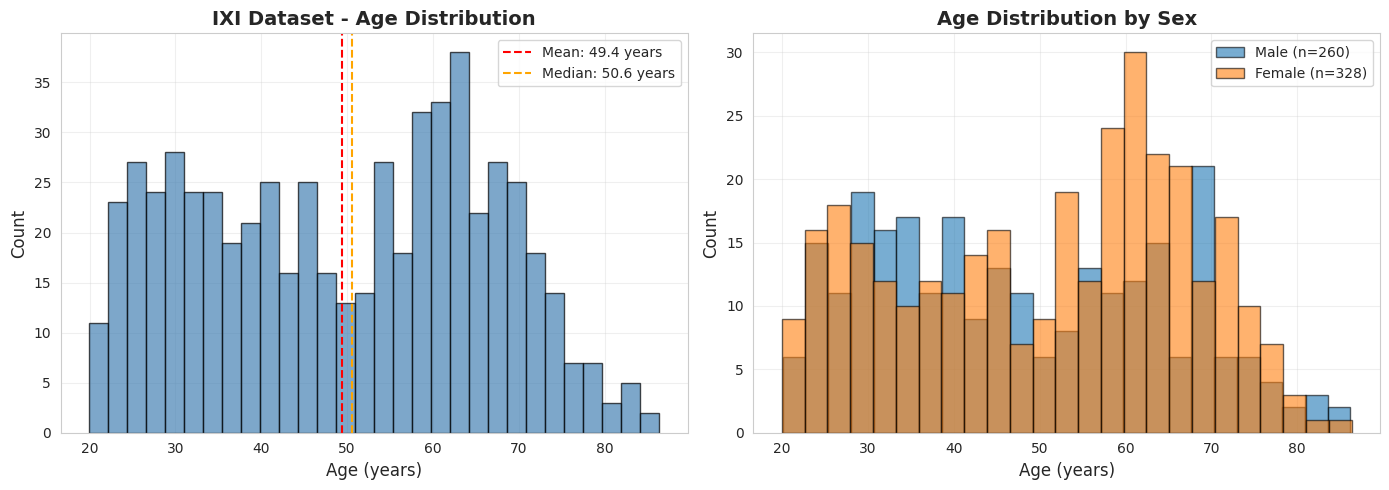


Age Statistics by Sex:
           count       mean        std        min       25%        50%  \
SEX_LABEL                                                                
Female     328.0  50.812574  16.519336  19.980835  36.33128  54.193018   
Male       260.0  47.687622  16.789976  20.071184  33.10130  45.735797   

                 75%        max  
SEX_LABEL                        
Female     63.613963  86.318960  
Male       62.240931  86.198494  


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall age distribution
axes[0].hist(ixi_valid['AGE'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(ixi_valid['AGE'].mean(), color='red', linestyle='--', 
                label=f"Mean: {ixi_valid['AGE'].mean():.1f} years")
axes[0].axvline(ixi_valid['AGE'].median(), color='orange', linestyle='--', 
                label=f"Median: {ixi_valid['AGE'].median():.1f} years")
axes[0].set_xlabel('Age (years)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('IXI Dataset - Age Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Age by sex
for sex in ['Male', 'Female']:
    sex_data = ixi_valid[ixi_valid['SEX_LABEL'] == sex]['AGE']
    axes[1].hist(sex_data, bins=25, alpha=0.6, label=f'{sex} (n={len(sex_data)})', edgecolor='black')

axes[1].set_xlabel('Age (years)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Age Distribution by Sex', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics by sex
print("\nAge Statistics by Sex:")
print(ixi_valid.groupby('SEX_LABEL')['AGE'].describe())

## 5. Site Distribution Analysis

/tmp/ipykernel_151969/743139103.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ixi_valid, x='SITE', y='AGE', order=site_order, ax=axes[1],


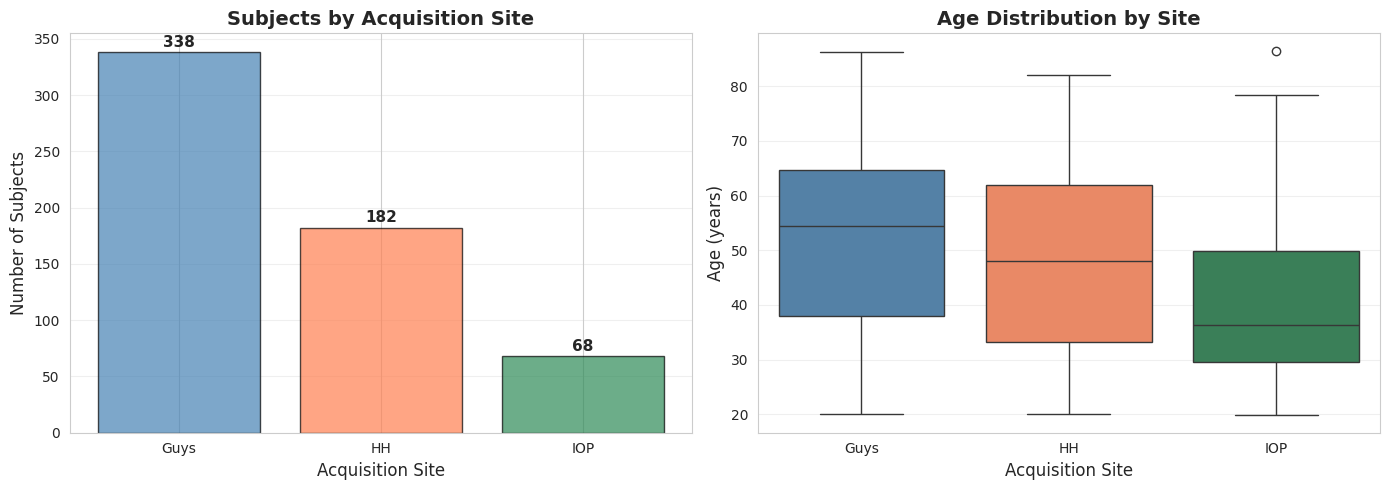


Age Statistics by Site:
      count       mean        std        min        25%        50%        75%  \
SITE                                                                            
Guys  338.0  51.921267  16.208757  20.071184  38.020534  54.351814  64.613963   
HH    182.0  47.442426  16.697169  20.167009  33.309377  48.076660  62.008898   
IOP    68.0  42.373475  16.599368  19.980835  29.562628  36.292950  49.840520   

            max  
SITE             
Guys  86.198494  
HH    81.941136  
IOP   86.318960  

Sex Distribution by Site:
SEX_LABEL  Female  Male  All
SITE                        
Guys          190   148  338
HH             94    88  182
IOP            44    24   68
All           328   260  588


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Site distribution
site_counts = ixi_valid['SITE'].value_counts()
axes[0].bar(site_counts.index, site_counts.values, color=['steelblue', 'coral', 'seagreen'], 
            edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Acquisition Site', fontsize=12)
axes[0].set_ylabel('Number of Subjects', fontsize=12)
axes[0].set_title('Subjects by Acquisition Site', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add counts on bars
for i, (site, count) in enumerate(site_counts.items()):
    axes[0].text(i, count + 5, str(count), ha='center', fontsize=11, fontweight='bold')

# Age by site (boxplot)
site_order = ixi_valid['SITE'].value_counts().index.tolist()
sns.boxplot(data=ixi_valid, x='SITE', y='AGE', order=site_order, ax=axes[1], 
            palette=['steelblue', 'coral', 'seagreen'])
axes[1].set_xlabel('Acquisition Site', fontsize=12)
axes[1].set_ylabel('Age (years)', fontsize=12)
axes[1].set_title('Age Distribution by Site', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics by site
print("\nAge Statistics by Site:")
print(ixi_valid.groupby('SITE')['AGE'].describe())

print("\nSex Distribution by Site:")
print(pd.crosstab(ixi_valid['SITE'], ixi_valid['SEX_LABEL'], margins=True))

## 6. Age and Sex Distribution Combined

/tmp/ipykernel_151969/4157753758.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ixi_valid, x='SEX_LABEL', y='AGE', ax=axes[0],


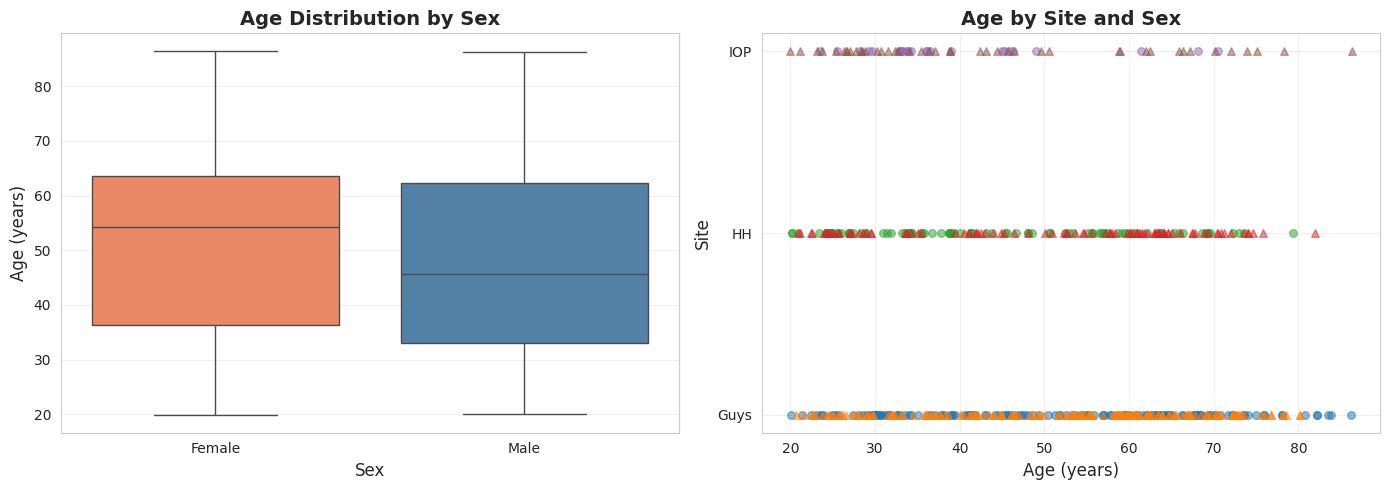

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Age by sex boxplot
sns.boxplot(data=ixi_valid, x='SEX_LABEL', y='AGE', ax=axes[0], 
            palette={'Male': 'steelblue', 'Female': 'coral'})
axes[0].set_xlabel('Sex', fontsize=12)
axes[0].set_ylabel('Age (years)', fontsize=12)
axes[0].set_title('Age Distribution by Sex', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Age distribution by site and sex
for site in site_order:
    site_data = ixi_valid[ixi_valid['SITE'] == site]
    axes[1].scatter(site_data[site_data['SEX_LABEL'] == 'Male']['AGE'], 
                   [site] * len(site_data[site_data['SEX_LABEL'] == 'Male']),
                   alpha=0.5, s=30, label=f'{site} - Male' if site == site_order[0] else '')
    axes[1].scatter(site_data[site_data['SEX_LABEL'] == 'Female']['AGE'], 
                   [site] * len(site_data[site_data['SEX_LABEL'] == 'Female']),
                   alpha=0.5, s=30, marker='^', 
                   label=f'{site} - Female' if site == site_order[0] else '')

axes[1].set_xlabel('Age (years)', fontsize=12)
axes[1].set_ylabel('Site', fontsize=12)
axes[1].set_title('Age by Site and Sex', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Data Quality Assessment

In [10]:
print("="*80)
print("IXI DATASET - DATA QUALITY SUMMARY")
print("="*80)

print(f"\n📊 OVERALL STATISTICS")
print(f"  Total subjects in metadata:           {len(metadata)}")
print(f"  Subjects with T1 NIfTI files:         {len(imaging_df)}")
print(f"  Subjects with complete data:          {len(ixi_valid)}")
print(f"  Completeness rate:                    {len(ixi_valid)/len(metadata)*100:.1f}%")

print(f"\n👥 DEMOGRAPHIC CHARACTERISTICS")
print(f"  Age range:                            {ixi_valid['AGE'].min():.1f} - {ixi_valid['AGE'].max():.1f} years")
print(f"  Mean age:                             {ixi_valid['AGE'].mean():.1f} ± {ixi_valid['AGE'].std():.1f} years")
print(f"  Median age:                           {ixi_valid['AGE'].median():.1f} years")
print(f"\n  Sex distribution:")
for sex, count in ixi_valid['SEX_LABEL'].value_counts().items():
    pct = count/len(ixi_valid)*100
    print(f"    {sex:10s}: {count:3d} ({pct:.1f}%)")

print(f"\n🏥 SITE DISTRIBUTION")
site_info = {
    'Guys': 'Guy\'s Hospital',
    'HH': 'Hammersmith Hospital',
    'IOP': 'Institute of Psychiatry'
}
for site, count in ixi_valid['SITE'].value_counts().items():
    pct = count/len(ixi_valid)*100
    full_name = site_info.get(site, site)
    print(f"  {site:4s} ({full_name:25s}): {count:3d} ({pct:.1f}%)")

print(f"\n✅ DATA AVAILABILITY")
print(f"  Subjects with HEIGHT:                 {ixi_valid['HEIGHT'].notna().sum()} ({ixi_valid['HEIGHT'].notna().sum()/len(ixi_valid)*100:.1f}%)")
print(f"  Subjects with WEIGHT:                 {ixi_valid['WEIGHT'].notna().sum()} ({ixi_valid['WEIGHT'].notna().sum()/len(ixi_valid)*100:.1f}%)")
print(f"  Subjects with STUDY_DATE:             {ixi_valid['STUDY_DATE'].notna().sum()} ({ixi_valid['STUDY_DATE'].notna().sum()/len(ixi_valid)*100:.1f}%)")

print("\n" + "="*80)

IXI DATASET - DATA QUALITY SUMMARY

📊 OVERALL STATISTICS
  Total subjects in metadata:           619
  Subjects with T1 NIfTI files:         581
  Subjects with complete data:          588
  Completeness rate:                    95.0%

👥 DEMOGRAPHIC CHARACTERISTICS
  Age range:                            20.0 - 86.3 years
  Mean age:                             49.4 ± 16.7 years
  Median age:                           50.6 years

  Sex distribution:
    Female    : 328 (55.8%)
    Male      : 260 (44.2%)

🏥 SITE DISTRIBUTION
  Guys (Guy's Hospital           ): 338 (57.5%)
  HH   (Hammersmith Hospital     ): 182 (31.0%)
  IOP  (Institute of Psychiatry  ):  68 (11.6%)

✅ DATA AVAILABILITY
  Subjects with HEIGHT:                 588 (100.0%)
  Subjects with WEIGHT:                 588 (100.0%)
  Subjects with STUDY_DATE:             588 (100.0%)



## 8. Dataset Composition for Normative Modeling

### Key Considerations:

**IXI Dataset Characteristics:**
- **All subjects are healthy controls** (no pathological group)
- Single timepoint per subject (cross-sectional design)
- Multi-site acquisition (3 sites in London)
- Wide age range covering adult lifespan

**Recommendations for Normative Modeling:**
1. ✅ **Use all subjects with complete data** - statistical independence satisfied (single timepoint)
2. ✅ **Include site as covariate** - account for scanner/protocol differences
3. ✅ **Consider age range** - excellent coverage for adult normative modeling
4. ⚠️ **Check sex balance** - may need to account for sex as covariate

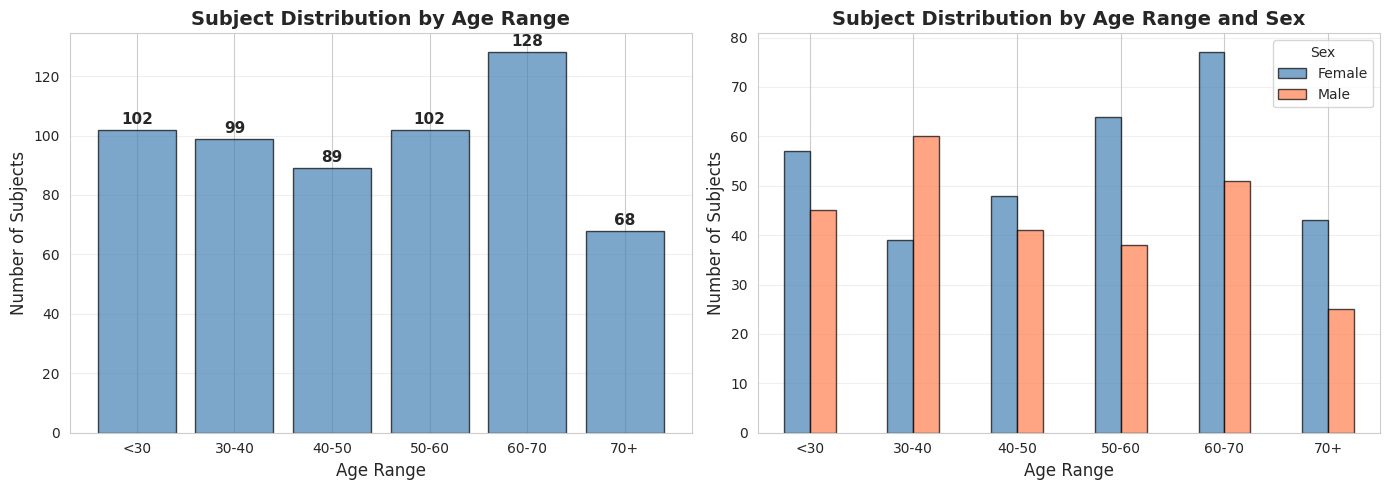


Subject Distribution by Age Range:
AGE_BIN
<30      102
30-40     99
40-50     89
50-60    102
60-70    128
70+       68
Name: count, dtype: int64

Subject Distribution by Age Range and Sex:
SEX_LABEL  Female  Male
AGE_BIN                
<30            57    45
30-40          39    60
40-50          48    41
50-60          64    38
60-70          77    51
70+            43    25


In [11]:
# Create age bins for better visualization
age_bins = [0, 30, 40, 50, 60, 70, 100]
age_labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70+']
ixi_valid['AGE_BIN'] = pd.cut(ixi_valid['AGE'], bins=age_bins, labels=age_labels)

# Age distribution by bins
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

age_bin_counts = ixi_valid['AGE_BIN'].value_counts().sort_index()
axes[0].bar(range(len(age_bin_counts)), age_bin_counts.values, 
            color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xticks(range(len(age_bin_counts)))
axes[0].set_xticklabels(age_bin_counts.index)
axes[0].set_xlabel('Age Range', fontsize=12)
axes[0].set_ylabel('Number of Subjects', fontsize=12)
axes[0].set_title('Subject Distribution by Age Range', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add counts on bars
for i, count in enumerate(age_bin_counts.values):
    axes[0].text(i, count + 2, str(count), ha='center', fontsize=11, fontweight='bold')

# Age and sex combined
age_sex_counts = pd.crosstab(ixi_valid['AGE_BIN'], ixi_valid['SEX_LABEL'])
age_sex_counts.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'], 
                    edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Age Range', fontsize=12)
axes[1].set_ylabel('Number of Subjects', fontsize=12)
axes[1].set_title('Subject Distribution by Age Range and Sex', fontsize=14, fontweight='bold')
axes[1].legend(title='Sex', loc='upper right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(age_sex_counts.index, rotation=0)

plt.tight_layout()
plt.show()

print("\nSubject Distribution by Age Range:")
print(age_bin_counts)
print("\nSubject Distribution by Age Range and Sex:")
print(age_sex_counts)

## 9. Export Final Dataset

In [12]:
# Prepare final dataset for export
ixi_export = ixi_valid[[
    'IXI_ID', 'SITE', 'SEX_ID (1=m, 2=f)', 'SEX_LABEL', 'AGE', 'HEIGHT', 'WEIGHT',
    'DOB', 'STUDY_DATE', 'nifti_path', 'nifti_filename'
]].copy()

# Rename columns for clarity
ixi_export = ixi_export.rename(columns={
    'SEX_ID (1=m, 2=f)': 'SEX_ID',
})

# Sort by IXI_ID
ixi_export = ixi_export.sort_values('IXI_ID').reset_index(drop=True)

# Save to CSV
output_file = OUTPUT_DIR / 'IXI_healthy_controls.csv'
ixi_export.to_csv(output_file, index=False)

print(f"✅ Dataset exported to: {output_file}")
print(f"\nFinal dataset:")
print(f"  Total subjects: {len(ixi_export)}")
print(f"  Age range: {ixi_export['AGE'].min():.1f} - {ixi_export['AGE'].max():.1f} years")
print(f"  Mean age: {ixi_export['AGE'].mean():.1f} ± {ixi_export['AGE'].std():.1f} years")
print(f"  Male/Female: {(ixi_export['SEX_ID'] == 1).sum()}/{(ixi_export['SEX_ID'] == 2).sum()}")
print(f"  Sites: {ixi_export['SITE'].value_counts().to_dict()}")

ixi_export.head(10)

✅ Dataset exported to: /home/mario/Repository/Normal_Alzeihmer/data/IXI/IXI_healthy_controls.csv

Final dataset:
  Total subjects: 588
  Age range: 20.0 - 86.3 years
  Mean age: 49.4 ± 16.7 years
  Male/Female: 260/328
  Sites: {'Guys': 338, 'HH': 182, 'IOP': 68}


,IXI_ID,SITE,SEX_ID,SEX_LABEL,AGE,HEIGHT,WEIGHT,DOB,STUDY_DATE,nifti_path,nifti_filename
0,2,Guys,2.0,Female,35.800137,164.0,58.0,1970-01-30,2005-11-18,/mnt/NAS-Progetti/IXI/2_Guys/T1/NIfTI/IXI002-G...,IXI002-Guys-0828-T1.nii.gz
1,12,HH,1.0,Male,38.781656,175.0,70.0,1966-08-20,2005-06-01,/mnt/NAS-Progetti/IXI/12_HH/T1/NIfTI/IXI012-HH...,IXI012-HH-1211-T1.nii.gz
2,13,HH,1.0,Male,46.710472,182.0,70.0,1958-09-15,2005-06-01,/mnt/NAS-Progetti/IXI/13_HH/T1/NIfTI/IXI013-HH...,IXI013-HH-1212-T1.nii.gz
3,14,HH,2.0,Female,34.236824,163.0,65.0,1971-03-15,2005-06-09,/mnt/NAS-Progetti/IXI/14_HH/T1/NIfTI/IXI014-HH...,IXI014-HH-1236-T1.nii.gz
4,15,HH,1.0,Male,24.284736,181.0,90.0,1981-03-11,2005-06-23,/mnt/NAS-Progetti/IXI/15_HH/T1/NIfTI/IXI015-HH...,IXI015-HH-1258-T1.nii.gz
5,16,Guys,1.0,Male,55.167693,172.0,63.0,1950-04-24,2005-06-24,/mnt/NAS-Progetti/IXI/16_Guys/T1/NIfTI/IXI016-...,IXI016-Guys-0697-T1.nii.gz
6,17,Guys,2.0,Female,29.092402,178.0,72.0,1976-05-21,2005-06-24,/mnt/NAS-Progetti/IXI/17_Guys/T1/NIfTI/IXI017-...,IXI017-Guys-0698-T1.nii.gz
7,19,Guys,1.0,Male,58.658453,180.0,88.0,1946-11-02,2005-06-30,/mnt/NAS-Progetti/IXI/19_Guys/T1/NIfTI/IXI019-...,IXI019-Guys-0702-T1.nii.gz
8,20,Guys,1.0,Male,39.466119,178.0,72.0,1966-01-05,2005-06-24,/mnt/NAS-Progetti/IXI/20_Guys/T1/NIfTI/IXI020-...,IXI020-Guys-0700-T1.nii.gz
9,21,Guys,2.0,Female,21.566051,165.0,64.0,1983-12-06,2005-06-30,/mnt/NAS-Progetti/IXI/21_Guys/T1/NIfTI/IXI021-...,IXI021-Guys-0703-T1.nii.gz
